# Notebook to explore how detsim works internally to change it to only the smearing part for the NN studies

In [411]:
import os

os.environ['ICTDIR'] = '/Users/mperez/NEXT/IC/'

import numpy as np
import pandas as pd
import tables as tb
from invisible_cities.dataflow import dataflow      as fl

import matplotlib.pyplot as plt

from invisible_cities.core.system_of_units import eV, mm, cm, ms, mus, ns, hertz

from invisible_cities.cities.components import check_max_time, MC_hits_from_files, create_timestamp, print_every
from invisible_cities.database          import load_db       as db

from invisible_cities.detsim.light_tables_c     import LT_SiPM
from invisible_cities.detsim.light_tables_c     import LT_PMT
from invisible_cities.detsim.simulate_electrons import generate_ionization_electrons, drift_electrons, diffuse_electrons

from invisible_cities.cities.detsim import filter_hits_after_max_time, hits_selector, ielectron_simulator, buffer_times_and_length_getter

from invisible_cities.io.mcinfo_io import load_mchits_df
from invisible_cities.core.configure import event_range

Explanation for event_range value: https://github.com/martinperezmaneiro/IC/blob/89fdf062a99ff79c476602bb32d4a0c3921437ce/invisible_cities/cities/components.py#L204

In [424]:
files_in    = ["/Users/mperez/detsim_vox/nexus/nexus_1_20evs_0nubb.h5"] #, "/Users/mperez/detsim_vox/nexus/nexus_1_20evs_1eroi.h5"
file_out    = "/Users/mperez/detsim_vox/detsim/prueba.h5"
compression = "ZLIB4"
run_number  = 0
detector_db = "next100"
print_mod   = 1
event_range = (None, )

s1_lighttable = "/Users/mperez/detsim_vox/LightTables/NEXT100_S1_LT.h5"
s2_lighttable = "/Users/mperez/detsim_vox/LightTables/NEXT100_S2_LT.h5"
sipm_psf      = "/Users/mperez/detsim_vox/LightTables/NEXT100_PSF.h5"

physics_params = dict(ws = 39.2 * eV,
                      wi = 22.0 * eV,
                      fano_factor = 0.15,
                      conde_policarpo_factor = 0.4,
                      drift_velocity         = 1.05  * mm / mus,
                      el_drift_velocity      = 4.55  * mm / mus,
                      transverse_diffusion   = 1.44  * mm / cm**0.5,
                      longitudinal_diffusion = 0.408 * mm / cm**0.5,
                      el_gain                = 855,
                      lifetime               =   10 * ms)

buffer_params = dict(pmt_width   =  25  * ns,
                     sipm_width  =   1  * mus,
                     max_time    = 3000 * mus,
                     length      = 1500 * mus,
                     pre_trigger =  10  * mus,
                     trigger_thr =   0)

rate = 0.5 * hertz

In [413]:
buffer_params_  = buffer_params .copy()
physics_params_ = physics_params.copy()

buffer_params_["max_time"] = check_max_time(buffer_params_["max_time"], buffer_params_["length"])

ws    = physics_params_.pop("ws")
el_dv = physics_params_.pop("el_drift_velocity")

# derived parameters
datapmt  = db.DataPMT (detector_db, run_number)
datasipm = db.DataSiPM(detector_db, run_number)
lt_pmt   = LT_PMT (fname=os.path.expandvars(s2_lighttable))
lt_sipm  = LT_SiPM(fname=os.path.expandvars(sipm_psf), sipm_database=datasipm)
el_gap   = lt_sipm.el_gap_width

In [414]:
for old_event in MC_hits_from_files(files_in, rate):
    break

In [415]:
for event in MC_hits_from_files(files_in, rate):
    break

#filters hits a times larger than max_time config parameter (ok?)
#filter_delayed_hits
event['x'], event['y'], event['z'], event['energy'], event['time'], event['label'] = filter_hits_after_max_time(buffer_params_["max_time"])(event['x'], 
                                                                                                                                            event['y'], 
                                                                                                                                            event['z'], 
                                                                                                                                            event['energy'], 
                                                                                                                                            event['time'], 
                                                                                                                                            event['label'], 
                                                                                                                                            event['event_number'])

#selecciona los hits que están en ACTIVE y BUFFER
#select_s1_candidate_hits
event['x'], event['y'], event['z'], event['energy'], event['time'], event['label'] = hits_selector(False)(event['x'], 
                                                                                                            event['y'], 
                                                                                                            event['z'], 
                                                                                                            event['energy'], 
                                                                                                            event['time'], 
                                                                                                            event['label'], 
                                                                                                            event['name'], 
                                                                                                            event['name_id'])

#selecciona los hits que están en ACTIVE
#select_active_hits
event['x_a'], event['y_a'], event['z_a'], event['energy_a'], event['time_a'], event['labels_a'] = hits_selector(True)(event['x'], 
                                                                                                                        event['y'], 
                                                                                                                        event['z'], 
                                                                                                                        event['energy'], 
                                                                                                                        event['time'], 
                                                                                                                        event['label'], 
                                                                                                                        event['name'], 
                                                                                                                        event['name_id'])

# checks if there is at least one active hit in the event
# filter_events_no_active_hits
event['passed_active'] = (lambda x:np.any(x))(event['energy_a'])

# writes for this event the variable "passed_active", that is, if there is at least one active hit in the event; not necessary to use here
# write_nohits_filter

# I understand that it filters the events that had "passed_active" as True, or counts them; not necesary  to use here
# events_passed_active_hits

After this first filtering proccess, detsim really starts. The next fucntion does almost it all:

* Simulates electron creation (generate_ionization_electrons)
* Drift (drift_electrons)
* Diffusion (diffuse_electrons)
* Photon generation in the EL (some final lines in the code)

I think that we wanted first to add diffusion only, without the EL effects. This function gives x, y, z with diffusion, and times + number of photons (which is for the second part). So, I think that having it up until here is enough! 

Now I should check how the rest of detsim works just to make sure these are the desired quantities to save!

I think I've solved the issue, so I paste here the changed functions:

In [416]:
def distribute_hits_energy_among_electrons(nes      : np.ndarray, 
                                           energies : np.ndarray) -> np.ndarray:
    """
    Distributes energy from each hit to its ionization electrons equally. 
    Energy from hits with zero ionization electrons is redistributed among 
    other hits, proportionally to their energy.

    Parameters:
        :nes: np.ndarray
            The ionization electrons per hit.
        :energies: np.ndarray
            Energy of each hits.

    Returns:
        :electron_energies: np.ndarray
            The energies of the ionization electrons.
    """
    electron_energies = []
    total_energy_to_redistribute = np.sum(energies[nes == 0])
    
    non_zero_indices = np.where(nes > 0)[0]
    total_energy_in_non_zero_hits = np.sum(energies[non_zero_indices])
    redistributed_energies = (energies[non_zero_indices] / total_energy_in_non_zero_hits) * total_energy_to_redistribute
    
    for i, idx in enumerate(non_zero_indices):
        n_electrons = nes[idx]
        energies_per_electron = np.full(n_electrons, energies[idx] / n_electrons)
        energies_per_electron += redistributed_energies[i] / n_electrons
        electron_energies.append(energies_per_electron)

    return np.concatenate(electron_energies)

def ielectron_simulator(*, wi: float, fano_factor: float, lifetime: float,
                        transverse_diffusion: float, longitudinal_diffusion: float, drift_velocity:float,
                        el_gain: float, conde_policarpo_factor: float):
    """
    Function that simulates electron creation, drift, diffusion and photon generation at the EL

    Parameters: floats
        parameter names are self-descriptive.
    Returns:
        :simulate_ielectrons:
            function that returns the positions emission times and number of photons at the EL
    """
    def simulate_ielectrons(x, y, z, time, energy):
        nelectrons = generate_ionization_electrons(energy, wi, fano_factor)
        nelectrons = drift_electrons(z, nelectrons, lifetime, drift_velocity)
        dx, dy, dz = diffuse_electrons(x, y, z, nelectrons, transverse_diffusion, longitudinal_diffusion)
        nelec_ener = distribute_hits_energy_among_electrons(nelectrons, energy)
        dtimes = dz/drift_velocity + np.repeat(time, nelectrons)
        nphotons = np.random.normal(el_gain, np.sqrt(el_gain * conde_policarpo_factor), size=nelectrons.sum())
        nphotons = np.round(nphotons).astype(np.int32)
        return dx, dy, dz, nelec_ener, dtimes, nphotons
    return simulate_ielectrons

### Me falta algo que quizás es importante/interesante, que es trackear de qué hit viene cada e- de ionización; para ello tendría que meter desde un principio ya algún argumento más, creo que incluso desde el MC_hits_from_files tendría que hacer que me yieldeara el hit number de los hits de MC, cosa que no hace; avisar si se necesita.

In [417]:
# this function does all the steps: simulates electron creation, drift, diffusion and photon generation in the EL
# the result gives all the ionization electrons, times (I think of arrival to the EL?) and the N of photons that generates each one
# simulate_electrons
event['x_ph'], event['y_ph'], event['z_ph'], event['energy_ph'], event['times_ph'], event['nphotons'] = ielectron_simulator(**physics_params_)(event['x_a'], 
                                                                                                                                                event['y_a'], 
                                                                                                                                                event['z_a'], 
                                                                                                                                                event['time_a'], 
                                                                                                                                                event['energy_a'])

# checks if the event has any photon
# count_photons
event['enough_photons'] = (lambda x:np.sum(x) > 0)(event['nphotons'])

# writes for this event the variable "enough_photons", that is, if there is at least one photon; not necessary to use for us
# write_dark_evt_filter

# I understand that it filters the events that had "enough_photons" as True, or counts them; not necesary  to use for us
# dark_events

quizás cambiar en diffuse electrons para que tb me dé una energía, porque es ahí cuando paso de un "numero de electrones" a tener una posición para cada uno, y por tanto es como el "hit" de ese electrón, puedo asignarle una energía :)

Si no, hacer una función a parte, es lo mismo en verdad

In [278]:
nelectrons = generate_ionization_electrons(event['energy_a'], physics_params_['wi'], physics_params_['fano_factor'])
nelectrons_drifted = drift_electrons(event['z_a'], nelectrons, physics_params_['lifetime'], physics_params_['drift_velocity'])

Después de crear el número de electrones de cada hit, lo que hago es repartir la energía para cada uno de ellos. Como hay hits que no tienen electrón de ionización, puedo hacer 2 cosas:

* Repartir esa energía igualitariamente entre todos los demás e- ionización que sí que existen (simple, da buen resultado, pero menos física quizás)
* Repartir esa energía proporcionalmente a cada hit, es decir, los e- ioniz de un hit más energético llevarán más parte de esa energía (algo más complicada, no sé si tiene más sentido físico, da igual de buen resultado, quizás un porquitín menos)

In [349]:
electron_energies = np.array([])
for i, n_electrons in enumerate(nelectrons_drifted):
    if n_electrons > 0:
        # Split the energy equally among the electrons
        energies_per_electron = np.full(n_electrons, event['energy'][i] / n_electrons)
    else:
        energies_per_electron = np.array([])
    
    electron_energies = np.append(electron_energies, energies_per_electron)

In [338]:
len(electron_energies), electron_energies.mean()

(107064, 2.29544987344502e-05)

Aquí está la diferencia por hacerlo de esta forma:

In [341]:
sum(event['energy']) - sum(electron_energies)

0.00022972049102909509

Solución simple: pillar toda la energía que no metí, dividirla y sumársela a cada hit de esos. Me parece que está bien porque al final es muy poquita, pero ayuda a que la energía final dé lo que tiene que dar :)

In [342]:
sum(electron_energies + sum(event['energy'][nelectrons_drifted == 0]) / len(electron_energies)) - sum(event['energy'])

1.2967404927621828e-13

Luego está la solución algo más compleja, con el código que ya lo hace entero:

In [368]:
def distribute_energy(nes      : np.ndarray, 
                      energies : np.ndarray) -> np.ndarray:
    """
    Distributes energy from each hit to its ionization electrons equally. 
    Energy from hits with zero ionization electrons is redistributed among 
    other hits, proportionally to their energy.

    Parameters:
        :nes: np.ndarray
            The ionization electrons per hit.
        :energies: np.ndarray
            Energy of each hits.

    Returns:
        :electron_energies: np.ndarray
            The energies of the ionization electrons.
    """
    electron_energies = []
    total_energy_to_redistribute = np.sum(energies[nes == 0])
    
    non_zero_indices = np.where(nes > 0)[0]
    total_energy_in_non_zero_hits = np.sum(energies[non_zero_indices])
    redistributed_energies = (energies[non_zero_indices] / total_energy_in_non_zero_hits) * total_energy_to_redistribute
    
    for i, idx in enumerate(non_zero_indices):
        n_electrons = nes[idx]
        energies_per_electron = np.full(n_electrons, energies[idx] / n_electrons)
        energies_per_electron += redistributed_energies[i] / n_electrons
        electron_energies.append(energies_per_electron)

    return np.concatenate(electron_energies)

In [369]:
np.concatenate(distribute_energy(nelectrons_drifted, event['energy'])).sum() - sum(event['energy'])

1.9055867994666187e-12

# I HAVE TO FIND WHERE DOES IT WRITE THE INFO...

# I HAVE TO CHECK IN ANOTHER CITY HOW DO THEY WRITE THE INFO AS REGULAR DFS

Me hago una idea de como lo haría yo, pero con lo de pipelines y esas mierdas a ver si soy capaz, intentaré extrapolar esto a una función o algo, pienso que voy a ser capaz VENGAAA :)

ME QUEDA SOLO CHEQUIAR COMO SE ESCRIBE!!

Agora creo una función que me lo pase a DataFrame

In [419]:
def diff_df_creator():
    def create_diff_df(evt, x, y, z, energy, time, nphotons):
        return pd.DataFrame({'event' : evt, 
                             'dx'       : x, 
                             'dy'       :y, 
                             'dz'       :z, 
                             'energy'   :energy, 
                             'time'     :time, 
                             'nphotons' :nphotons})
    return create_diff_df

In [420]:
event['diff_df'] = diff_df_creator()(event['event_number'], 
                                     event['x_ph'], 
                                     event['y_ph'], 
                                     event['z_ph'], 
                                     event['energy_ph'], 
                                     event['times_ph'], 
                                     event['nphotons'])

In [423]:
from invisible_cities.io.dst_io import df_writer

In [422]:
def diff_writer(h5out):
    """
    For a given open table returns a writer for diffusion electrons dataframe
    """
    def write_diff(df):
        return df_writer(h5out              = h5out                      ,
                         df                 = df                         ,
                         group_name         = 'Detsim'                   ,
                         table_name         = 'Diff_electrons'           ,
                         descriptive_string = 'Diffused electrons'       ,
                         columns_to_index   = ['event']                  )
    return write_diff

,event_id,dx,dy,dz,energy,time,nphotons
0,0,-244.969579,-233.821455,307.465229,0.000023,292824.030721,862
1,0,-245.985711,-253.175751,310.972894,0.000023,296164.664370,838
2,0,-238.519473,-244.711732,312.062402,0.000023,297202.290894,893
3,0,-242.794303,-231.800237,311.041566,0.000023,296230.066672,842
4,0,-242.230913,-234.158755,314.725321,0.000023,299738.404332,868
...,...,...,...,...,...,...,...
107265,0,-251.265738,-242.188561,294.138737,0.000018,280132.342878,873
107266,0,-241.424615,-236.033050,291.220613,0.000018,277353.177176,843
107267,0,-246.885085,-232.454532,292.814749,0.000018,278871.401402,820
107268,0,-244.816796,-225.359497,294.180876,0.000018,280172.474713,868


In [404]:
event.keys()

dict_keys(['event_number', 'x', 'y', 'z', 'energy', 'time', 'label', 'timestamp', 'name', 'name_id', 'x_a', 'y_a', 'z_a', 'energy_a', 'time_a', 'labels_a', 'passed_active', 'x_ph', 'y_ph', 'z_ph', 'energy_ph', 'times_ph', 'nphotons', 'enough_photons'])

In [410]:
pd.DataFrame({key: event[key] for key in ['event_number', 'x_ph', 'y_ph', 'z_ph', 'energy_ph', 'times_ph', 'nphotons']})

,event_number,x_ph,y_ph,z_ph,energy_ph,times_ph,nphotons
0,0,-235.931588,-246.971149,314.868622,0.000023,299874.881581,869
1,0,-231.125470,-255.815644,312.536288,0.000023,297653.610656,835
2,0,-227.445967,-256.262659,315.089556,0.000023,300085.294743,860
3,0,-251.616102,-229.281768,315.282510,0.000023,300269.060963,888
4,0,-236.995367,-234.344907,313.197283,0.000023,298283.129620,864
...,...,...,...,...,...,...,...
107197,0,-243.740833,-226.165115,295.133561,0.000012,281079.794452,826
107198,0,-244.280349,-240.934088,293.620756,0.000012,279639.027253,870
107199,0,-248.363524,-237.915571,291.163517,0.000012,277298.799430,846
107200,0,-253.611781,-246.231148,291.748618,0.000012,277856.038444,852


In [394]:
keys_to_select = ['x_ph', 'y_ph', 'z_ph', 'energy_ph', 'times_ph', 'nphotons']

smear_event = {key: event[key] for key in keys_to_select}

In [397]:
sum(event['energy']) - sum(smear_event['energy_ph'])

1.5210055437364645e-11

In [398]:
pd.DataFrame(smear_event)

,x_ph,y_ph,z_ph,energy_ph,times_ph,nphotons
0,-235.931588,-246.971149,314.868622,0.000023,299874.881581,869
1,-231.125470,-255.815644,312.536288,0.000023,297653.610656,835
2,-227.445967,-256.262659,315.089556,0.000023,300085.294743,860
3,-251.616102,-229.281768,315.282510,0.000023,300269.060963,888
4,-236.995367,-234.344907,313.197283,0.000023,298283.129620,864
...,...,...,...,...,...,...
107197,-243.740833,-226.165115,295.133561,0.000012,281079.794452,826
107198,-244.280349,-240.934088,293.620756,0.000012,279639.027253,870
107199,-248.363524,-237.915571,291.163517,0.000012,277298.799430,846
107200,-253.611781,-246.231148,291.748618,0.000012,277856.038444,852


In [399]:
import sys
sys.path.append(os.getenv('HOME') + '/NEXT/data_labelling/')

from utils.plotting_utils import plot_3d_hits

In [431]:
diff_file = load_dst(file_out, 'Detsim', 'Diff_electrons')
diff_event = diff_file[diff_file.event == 0]

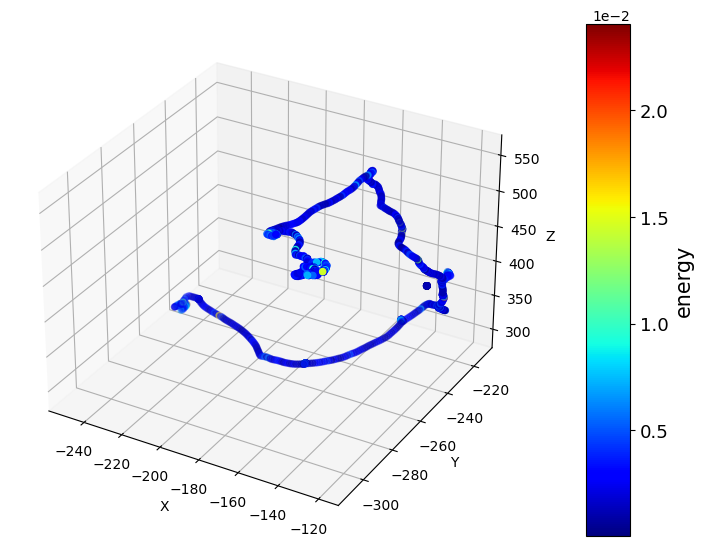

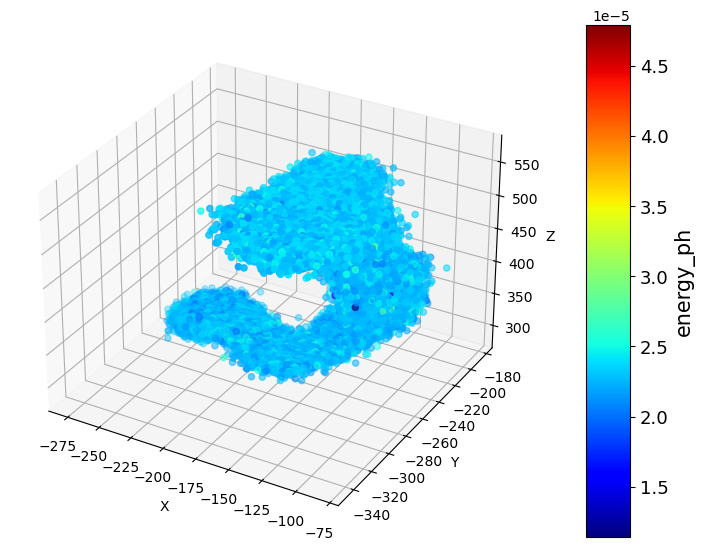

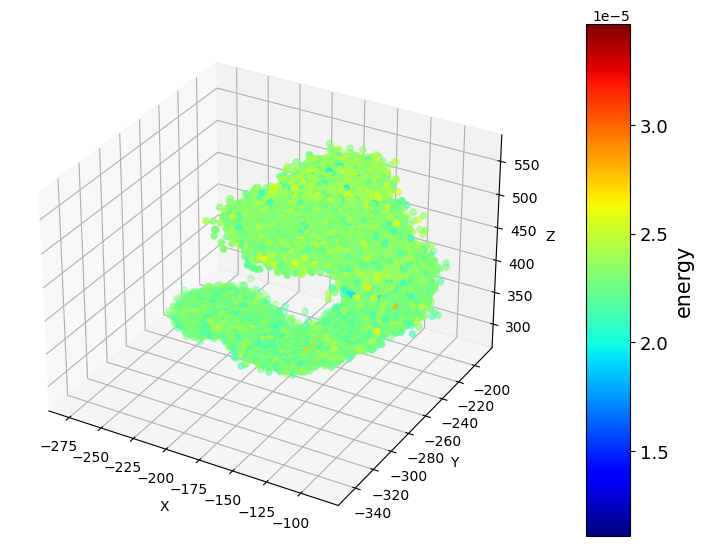

In [445]:
plot_3d_hits(pd.DataFrame(old_event))

plot_3d_hits(pd.DataFrame(smear_event), 'energy_ph', coords=['x_ph', 'y_ph', 'z_ph'])

plot_3d_hits(diff_event, 'energy', coords=['dx', 'dy', 'dz'])

They are not exactly the same because these functions are not deterministic, there is a part of random distribution in the creation of ionization electrons